<!-- dom:TITLE: Homework 7, PHY 959 -->
<!-- dom:AUTHOR: [PHY 959: Machine Learning in Physics]-->

# PHY 959: Homework Set #7
Due: **April 23, 2021**
***
***

# Bayesian classification with out-of-domain testing points

In this notebook you will compare the performance of a classical neural network and a Bayesian neural network for classification. In particular, you will test your model on out-of-domain testing points. 

Each model will be trained on the MNIST dataset, which is made of pictures of hand-written digits from 0 to 9. The testing data set will be instead images from one of the classes in the CIFAR-10 dataset (which consists of 60000 32x32 colour images in 10 classes). 

In [ ]:
# Some setup
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import keras_preprocessing
from keras_preprocessing import image
from keras.datasets import mnist
print('TensorFlow version :', tf.__version__)
print('TensorFlow Probability version :', tfp.__version__)

TensorFlow version : 2.4.1
TensorFlow Probability version : 0.12.1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import random  

%matplotlib inline
plt.rcParams['figure.figsize'] = (9,9) 

np.random.seed(1861)
tf.random.set_seed(1861)


Load the traning dataset and do some preprocessing

In [ ]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


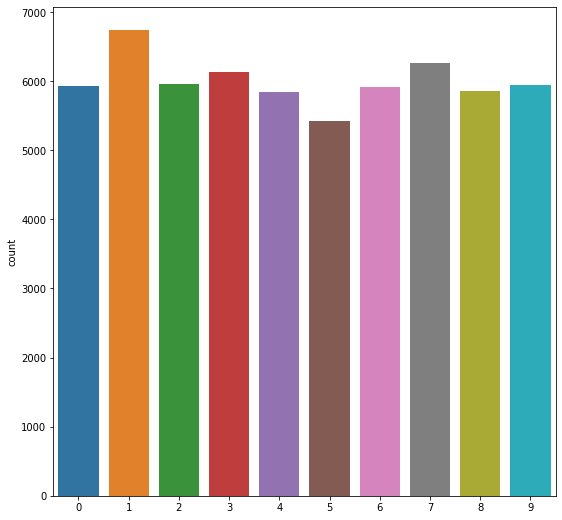

In [ ]:
#Visualize the distribution 
g = sns.countplot(y_train)

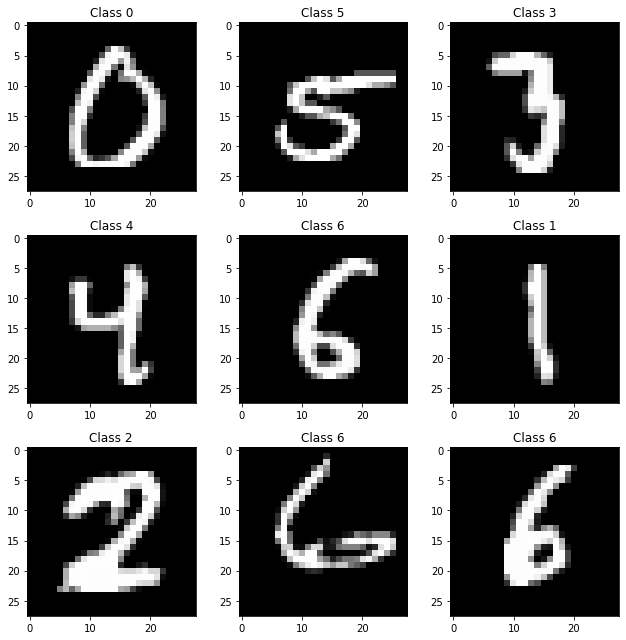

In [ ]:
# Plot some images in the dataset
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(x_train))
    plt.imshow(x_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

In [ ]:
X_train = x_train.reshape(x_train.shape[0], 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = x_test.reshape(x_test.shape[0], 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [ ]:
# Convert classes (unique digits) to categorical format
from keras.utils import np_utils   
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
# Create training and validation datasets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)

(42000, 784)
(18000, 784)


## Train classical neural network

In [ ]:
# Define model
from keras.models import Sequential  
from keras.layers.core import Dense, Dropout, Activation 

model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],))) 
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from pathlib import Path
model_file_name = 'DNN_model.h5'
my_file = Path(model_file_name)
plotHistory = True
if not my_file.exists():
  history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
            batch_size=128, epochs=30, verbose=1)
  model.save(model_file_name)
else:
  model = tf.keras.models.load_model(model_file_name)
  plotHistory = False

In [ ]:
if plotHistory:
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylim(0, 1)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

## Predictions 

Load the CIFAR-10 data set to make predictions on an unknown class. 

In [ ]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()
print(x_train_raw.shape)   

(50000, 32, 32, 3)


Let's look at one random image in the dataset

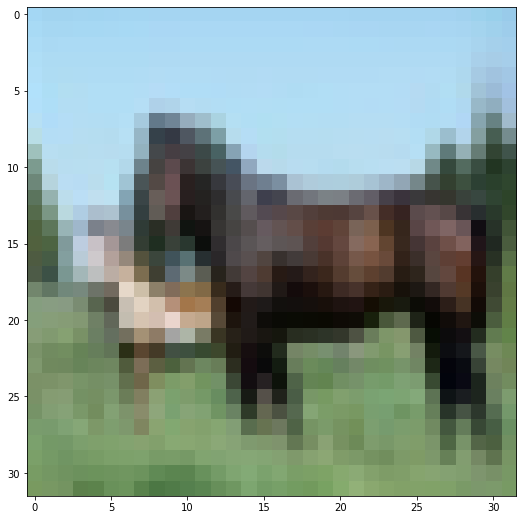

In [ ]:
plt.imshow(x_train_raw[12], interpolation='none')

In [ ]:
# Resize image from 32x32 to 28x28
# Note: this step is quite slow! 
from skimage.transform import resize
x_train_raw = np.array([resize(img, (28, 28, 3)) for img in x_train_raw ])
x_test_raw = np.array([resize(img, (28, 28, 3)) for img in x_test_raw ])

In [ ]:
# Convert image from RGB to grey scale
rgb_weights = [0.2989, 0.5870, 0.1140]
x_train_raw = np.dot(x_train_raw[...,:3], rgb_weights)
x_test_raw = np.dot(x_test_raw[...,:3], rgb_weights)

In [ ]:
# Normalize
x_train_raw = x_train_raw/255.0
x_test_raw = x_test_raw/255.0

Let's look at the same image after the preprocessing

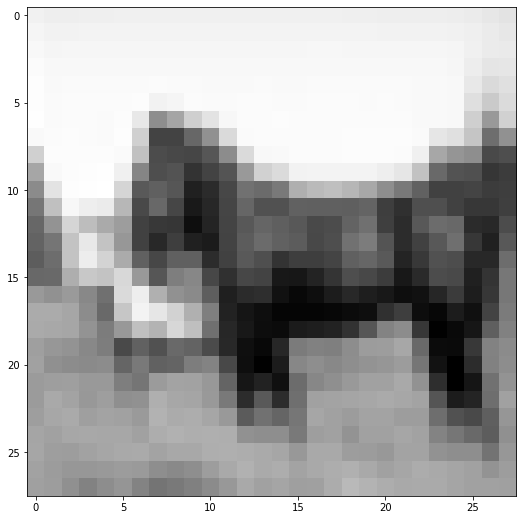

In [ ]:
plt.imshow(x_train_raw[12], cmap='gray', interpolation='none')

In [ ]:
# Reshape matrices into vectors
x_train_reshaped = x_train_raw.reshape(x_train_raw.shape[0],x_train_raw.shape[1]*x_train_raw.shape[2])
x_test_reshaped = x_test_raw.reshape(x_test_raw.shape[0],x_test_raw.shape[1]*x_test_raw.shape[2])

In [ ]:
# Select images of class 7 (horses)
x_unknown_class = x_test_reshaped[np.where(y_test_raw==7)[0]]
y_unknown_class = y_test_raw[np.where(y_test_raw==7)]
print(x_unknown_class.shape)
print(y_unknown_class.shape)

(1000, 784)
(1000,)


In [ ]:
# Make predictions
predictions = model.predict(x_unknown_class)
pred_classes = np.argmax(predictions, axis=-1)


<BarContainer object of 10 artists>

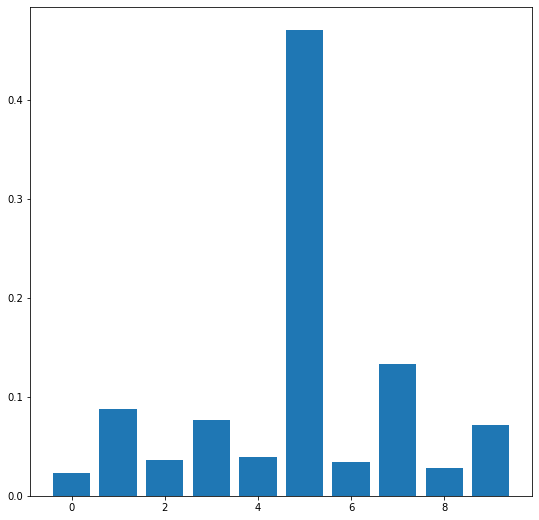

In [ ]:
# Look at prediction for one testing example
X = np.arange(10)
plt.bar(X,predictions[12])

***
***
# Bayesian neural network

Now build and train a Bayesian neural network to perform the same classification task on the MNIST dataset. 

Use the trained BNN to produce an ensemble of predictions. 

Check the predictions for the same out-of-sample testing example as above. Comment on the differences that you observe between the Bayesian NN and the traditional fully-connected DNN.  In particular, did the classification perform in the manner that you expected?